In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test

In [2]:
train_proteins_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
print(train_proteins_df.shape)
print(train_proteins_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_proteins_df.head(10)

train_peptides_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
print(train_peptides_df.shape)
print(train_peptides_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_peptides_df.head(10)

(232741, 5)
33.64677047729492  MBs
(981834, 6)
212.76564979553223  MBs


In [3]:
pro_pep_join = pd.merge(train_proteins_df, train_peptides_df, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')

del train_proteins_df, train_peptides_df
gc.collect()

train_clinical_data_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
print(train_clinical_data_df.shape)
print(train_clinical_data_df.memory_usage(deep=True).sum()/1024/1024, " MBs")

full_training_data = pd.merge(pro_pep_join, train_clinical_data_df, on=['patient_id','visit_id','visit_month'], how='inner')

del pro_pep_join, train_clinical_data_df
gc.collect()

full_training_data = full_training_data.drop(columns=['UniProt','Peptide','upd23b_clinical_state_on_medication'])

print(full_training_data.shape)
full_training_data.head(10)

(2615, 8)
0.3944511413574219  MBs
(941744, 9)


,visit_id,visit_month,patient_id,NPX,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,0,55,11254.3,11254.3,10.0,6.0,15.0,NaN
1,55_0,0,55,732430.0,102060.0,10.0,6.0,15.0,NaN
2,55_0,0,55,732430.0,174185.0,10.0,6.0,15.0,NaN
3,55_0,0,55,732430.0,27278.9,10.0,6.0,15.0,NaN
4,55_0,0,55,732430.0,30838.7,10.0,6.0,15.0,NaN
5,55_0,0,55,732430.0,23216.5,10.0,6.0,15.0,NaN
6,55_0,0,55,732430.0,170878.0,10.0,6.0,15.0,NaN
7,55_0,0,55,732430.0,148771.0,10.0,6.0,15.0,NaN
8,55_0,0,55,732430.0,55202.1,10.0,6.0,15.0,NaN
9,55_0,0,55,39585.8,27229.3,10.0,6.0,15.0,NaN


In [4]:
full_training_data_melted = full_training_data.melt(id_vars=['visit_id','visit_month','patient_id','NPX','PeptideAbundance']
                                                    , value_vars=['updrs_1','updrs_2','updrs_3','updrs_4'],var_name='updrs_test', value_name='updrs_test_score')

list_of_updrs_tests = full_training_data_melted.updrs_test.unique()

temp_df = full_training_data_melted.groupby(['updrs_test']).agg(visit_month_per_patient=('visit_id', 'count')
                                                      , mean_updrs_test_score=('updrs_test_score', 'mean') ).reset_index(level=['updrs_test'])

for i in range(len(list_of_updrs_tests)):
    print(list_of_updrs_tests[i])
    updrs_test_mean = full_training_data[list_of_updrs_tests[i]].mean()
    print(updrs_test_mean)
    full_training_data.fillna({list_of_updrs_tests[i]:updrs_test_mean}, inplace=True)

updrs_1
6.506168342989177
updrs_2
5.781904636504188
updrs_3
17.205188800631337
updrs_4
1.8879240409258773


In [5]:
full_training_data_melted = full_training_data.melt(id_vars=['visit_id','visit_month','patient_id','NPX','PeptideAbundance']
                                                    , value_vars=['updrs_1','updrs_2','updrs_3','updrs_4'],var_name='updrs_test', value_name='updrs_test_score')

full_training_data_melted['group_key'] = full_training_data_melted['visit_month']
full_training_data_melted['row_id'] = full_training_data_melted['visit_id'] + '_' + full_training_data_melted['updrs_test']

full_training_data_melted[full_training_data_melted['visit_id']=='55_0']

,visit_id,visit_month,patient_id,NPX,PeptideAbundance,updrs_test,updrs_test_score,group_key,row_id
0,55_0,0,55,11254.3,11254.3,updrs_1,10.000000,0,55_0_updrs_1
1,55_0,0,55,732430.0,102060.0,updrs_1,10.000000,0,55_0_updrs_1
2,55_0,0,55,732430.0,174185.0,updrs_1,10.000000,0,55_0_updrs_1
3,55_0,0,55,732430.0,27278.9,updrs_1,10.000000,0,55_0_updrs_1
4,55_0,0,55,732430.0,30838.7,updrs_1,10.000000,0,55_0_updrs_1
...,...,...,...,...,...,...,...,...,...
2826158,55_0,0,55,408698.0,98654.3,updrs_4,1.887924,0,55_0_updrs_4
2826159,55_0,0,55,408698.0,218723.0,updrs_4,1.887924,0,55_0_updrs_4
2826160,55_0,0,55,29758.8,29758.8,updrs_4,1.887924,0,55_0_updrs_4
2826161,55_0,0,55,23833.7,23833.7,updrs_4,1.887924,0,55_0_updrs_4


In [6]:
"""print(full_training_data_melted.group_key.nunique())
print(full_training_data_melted.shape)"""
## 15, (3766976, 9)
print(full_training_data_melted.updrs_test_score.unique())
print(full_training_data_melted.group_key.unique())

[10.         11.          2.          1.          8.          6.
  9.         12.          5.          7.          4.         17.
  3.          0.         14.         16.         15.         20.
 18.         13.         33.         28.         25.         26.
 19.         21.         24.         22.         23.         27.
 29.         36.         38.         30.         46.         41.
 40.         39.         47.         32.         31.         34.
 56.         52.         35.         17.2051888  51.         44.
 68.         43.         67.         61.         45.         59.
 37.         48.         42.         60.         55.         49.
 63.         78.         58.         50.         66.          1.88792404]
[  0   3   6  12  18  24  30  36  48  54  60  72  84  96 108]


In [7]:
full_training_data_melted.isna().sum()

visit_id            0
visit_month         0
patient_id          0
NPX                 0
PeptideAbundance    0
updrs_test          0
updrs_test_score    0
group_key           0
row_id              0
dtype: int64

In [8]:
full_training_data_melted[['updrs_test_score','PeptideAbundance','NPX']].corr()

,updrs_test_score,PeptideAbundance,NPX
updrs_test_score,1.000000,-0.000617,-0.001110
PeptideAbundance,-0.000617,1.000000,0.506847
NPX,-0.001110,0.506847,1.000000


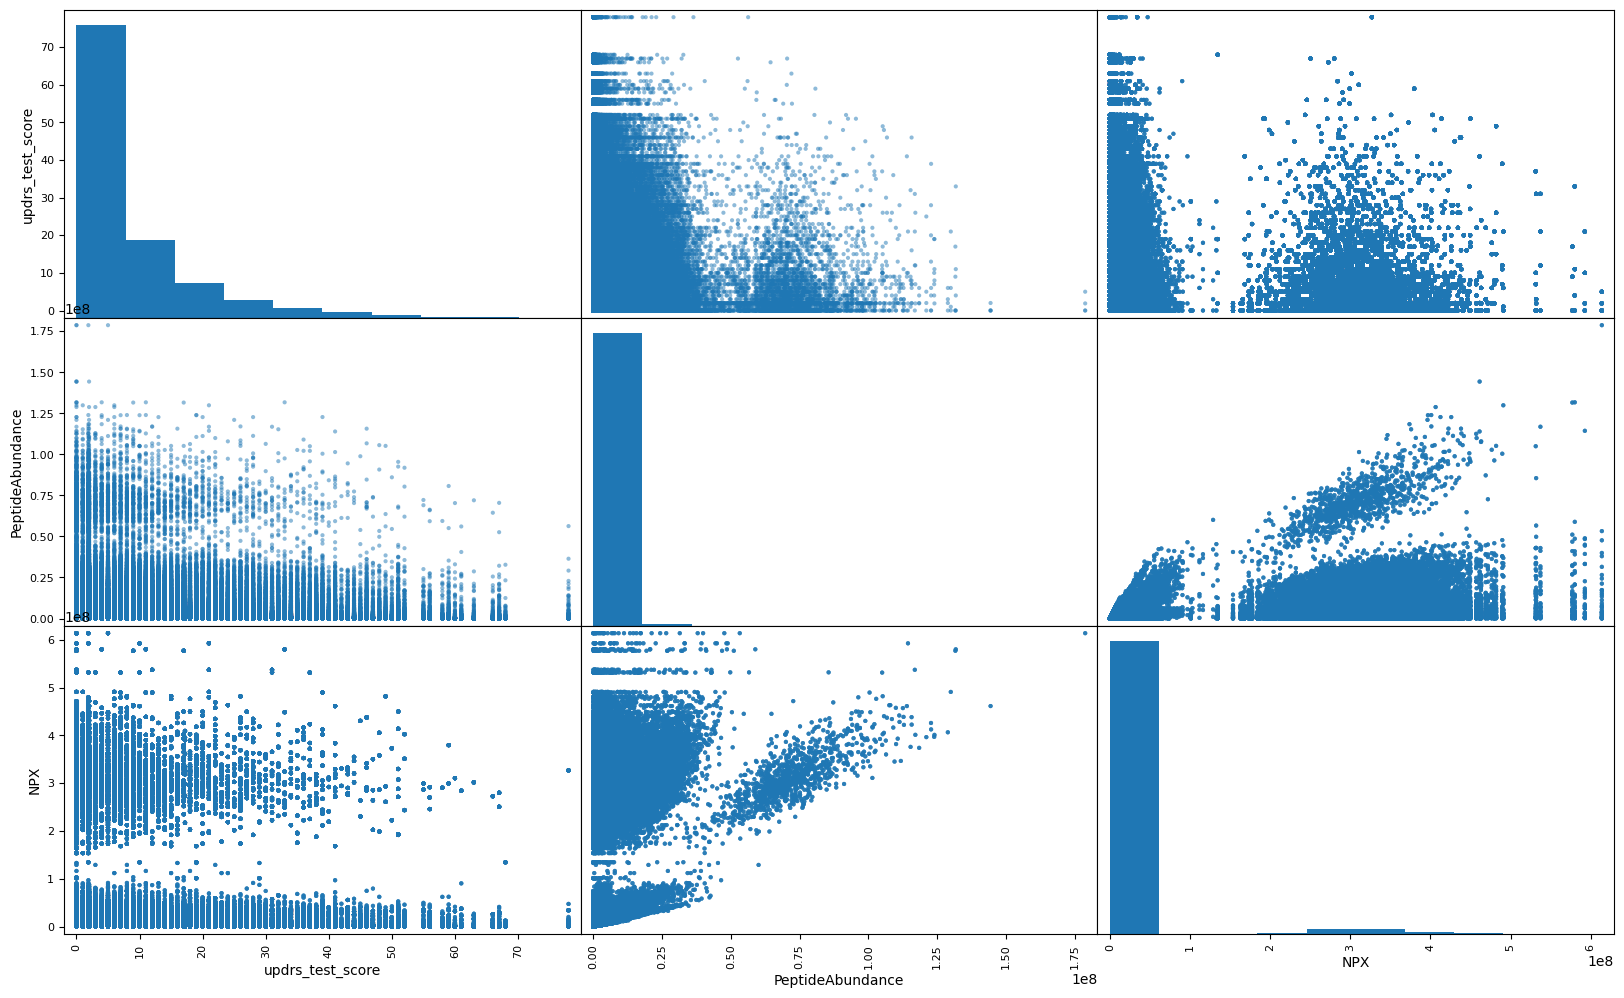

In [9]:
attributes = ['updrs_test_score', 'PeptideAbundance', 'NPX']

scatter_plot_arr = scatter_matrix(full_training_data_melted[attributes], figsize=(20,12))

<AxesSubplot:xlabel='NPX', ylabel='PeptideAbundance'>

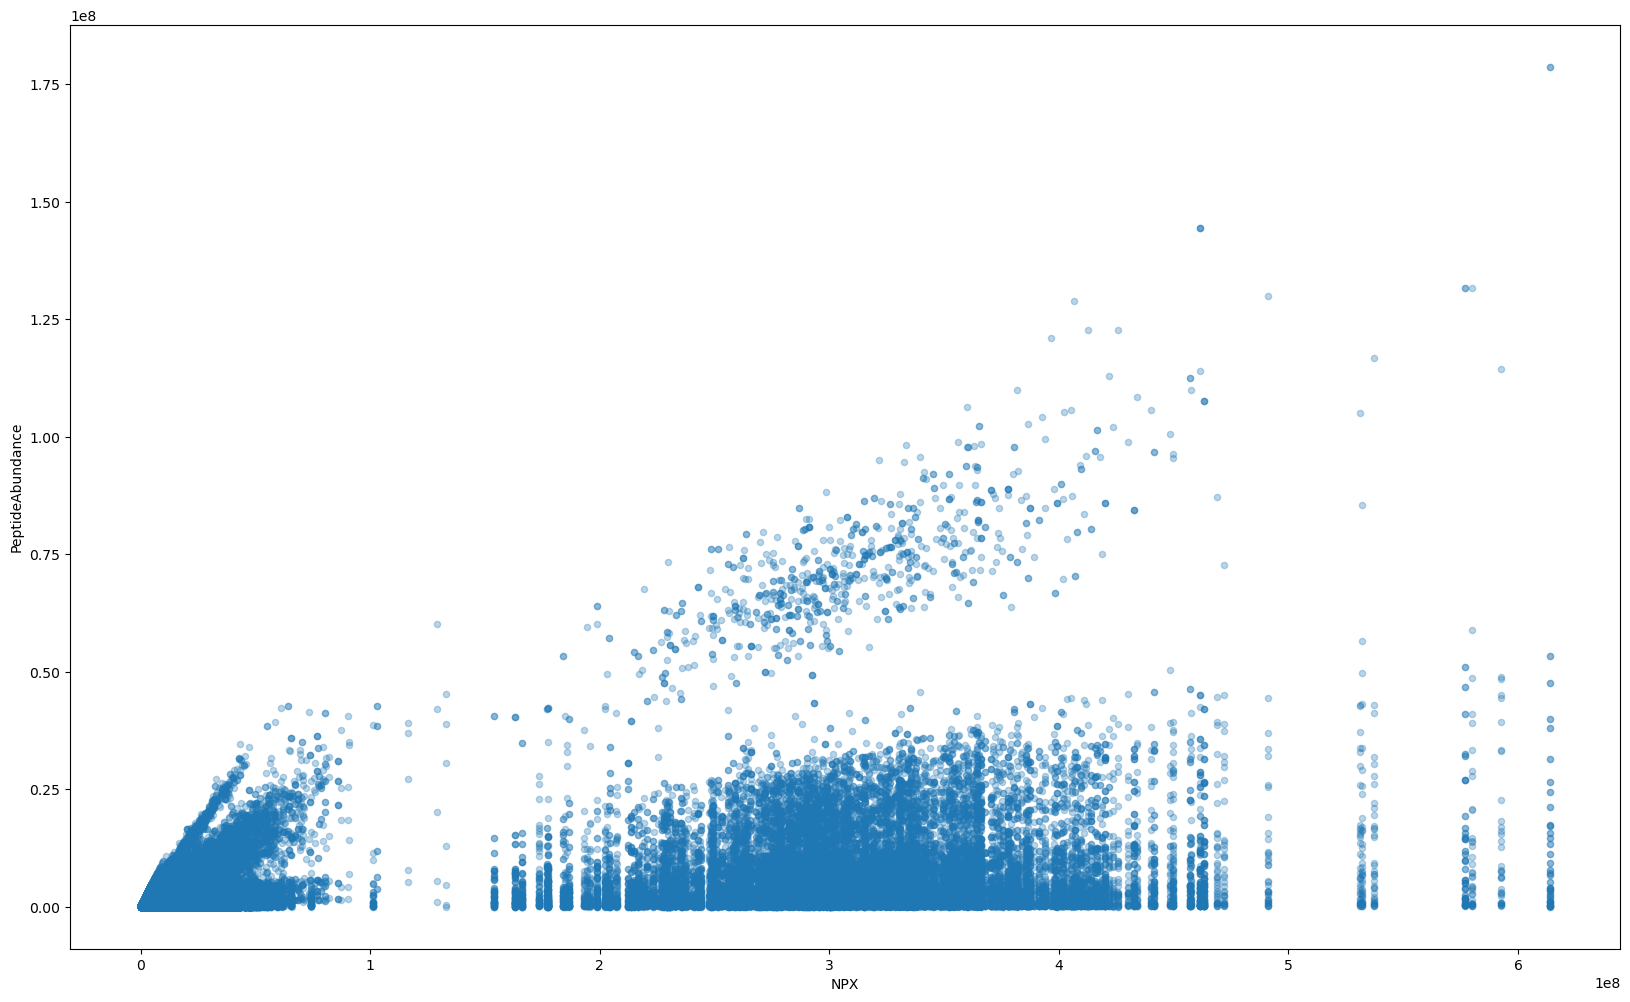

In [10]:
full_training_data_melted[full_training_data_melted['updrs_test_score']==0].plot(kind="scatter", x="NPX", y="PeptideAbundance", alpha=0.3, figsize=(20,12))